<a href="https://colab.research.google.com/github/livadlivesey/Coursework/blob/main/OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evolving Agents to solve openAI tasks**



*   Evolve an agent to solve tasks in openAI gym
*   Agent implemented as a neural network, evolving weights and biases

## OpenAI gym


*   Each agent should work with any gym environment
*   Used in reinforcement learning
*   OpenAI acts as environment












1.   Task is to create an agent which takes in **observations** (numbers from environment) and outputs actions
2.   Goal is to **maximise reward**


The goal is now to encode information abot this "policy" neural network in genes and use **evolutionary algorithms**. The **fitness function** is the reward from the environment.

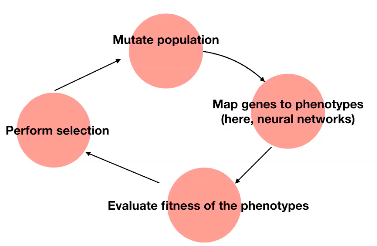





Imports

In [ ]:
import tensorflow as tf
device_name = tf.profiler
print(device_name)


<module 'tensorflow._api.v2.profiler' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/profiler/__init__.py'>


SystemError: ignored

In [ ]:
!apt-get update
!apt install xvfb 
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch

from random import randrange
import math
from copy import deepcopy


!pip install colabgymrender
from colabgymrender.recorder import Recorder


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

# Functions for Cartpole

In [ ]:

def run_episode(env, agent):
  #Wraps a simulation of the cartpole task in a function and returns the reward for that agent
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

def run_episode2(env, agent):
  #Wraps a simulation of the cartpole task in a function for a given agent
  #Returns the rewards and observations for the agent 
    tot_reward = 0.0
    obs = env.reset()
    done = False
    observations = []
    while not done:
        action = agent.get_action(obs)
        #Perform an episode and return the states and reward
        obs, reward, done, info = env.step(action)
        #Record the observations at each episode
        observations.append(obs)
        #Add cumulative reward
        tot_reward = tot_reward + reward
    return tot_reward, observations

def run_episode3(env, agent):
  #Wraps a simulation of the cartpole task in a function and returns the rewards and observations for the agent
    tot_reward = 0.0
    obs = env.reset()
    done = False
    observations = []
    cum_rewards=[]
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        observations.append(obs)
        tot_reward = tot_reward + reward
        cum_rewards.append(tot_reward)
    return cum_rewards, observations

def visual_episode(env, agent=None):
  #Allows us to visualise the actions of an agent in the cartpole task
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward


def fitness_function(env, agent, population):
    # Get fitness array for the whole population
    #This function is used to evaluate the fitness of the population initially and at the end of each tournament
    #loops over each gene in population, set the agent to have those genes and then run episode (simulation)
    #returns a single value of reward for each genotype

    pop_size = population.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(population):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

def fitness_function2(env, agent, gene):
    #
    agent.set_genes(gene)
    fit = run_episode(env, agent)
    return fit

def fitness_function3(env, agent, gene):
    
    agent.set_genes(gene)
    fit, obs = run_episode3(env, agent)
    return fit, obs

def mutate(population, mean=0, std=0.1):
    '''
    This function introduces a creep mutation to the genotype, and constrains it within -4 and 4
    '''
    for i, gene in enumerate(population):
        population[i] = population[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    population[population > 4] = 4
    population[population < -4] = -4

    return population

def mutation_function(population,mutation_rate, mean=0, std=0.1):
    '''
    This function introduces a creep mutation to the genotype, if the random number exceeds the mutation rate threshold.
    '''

    for i, gene in enumerate(population):
        if random.uniform(0,1)>mutation_rate:
          population[i] = population[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    population[population > 4] = 4
    population[population < -4] = -4

    return population


def get_best_gene(population, fitness):
    i = np.argmax(fitness)
    return population[i]

# Agent:

In [ ]:
class Agent:
  '''This class creates a single layer perceptron to represent an agent for the cartpole task'''
    def __init__(self, num_input, num_output):
      self.num_input = num_input 
      self.num_output = num_output
      self.num_genes = num_input * num_output + num_output
      self.weights = None
      self.bias = None
      

    def set_genes(self, gene):
      #Gene is a list of numbers which are mapped to weights and biases
      #The first section of the gene encodes the weights, the second section encodes the biases
      
      weight_idxs = self.num_input * self.num_output
      bias_idxs = self.num_input * self.num_output + self.num_output
      w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
      b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
      self.weights = torch.from_numpy(w)
      self.bias = torch.from_numpy(b)

    def forward(self, x):
      #Perform matrix multiplication of the weighted inputs and bias to determine output
      x = torch.from_numpy(x).unsqueeze(0)
      return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
      #Return the action that the agent takes using a 'step' function approach
      if self.forward(x) > 0:
          return 1
      else:
          return 0



## Genetic Algorithm:

In [ ]:
def compare2(g1,g2,population):
  #Function to compare the fitnesses of two genotypes and determine the winner
  #Returns "zero" and "draw" which is dealt with by the microbial GA
  winner = "zero"
  if fitness_function2(env, agent, population[g1]) > fitness_function2(env, agent, population[g2]):
    winner = "g1"

  if fitness_function2(env, agent, population[g1]) < fitness_function2(env, agent, population[g2]):
    winner = "g2"
  #If both genotypes have the 0 fitness, return "zero" 
  if fitness_function2(env, agent, population[g1]) == 0 and fitness_function2(env, agent, population[g2]) == 0:
    winner = "zero"
  #If both genotypes have the same fitness, but not 0, return "draw"
  if fitness_function2(env, agent, population[g1]) == fitness_function2(env, agent, population[g2]) and fitness_function2(env, agent, population[g2]) != 0 :
    winner = "draw"

  return winner

def crossover(winner, loser, pcrossover):
  #A method to recombine the loser with the winner according to some probability pcrossover (0.5)
  for i in range(winner.shape[0]):
    if randrange(0,10) < pcrossover*10:
      #Overcopy the gene at the position with that gene in the winner
      loser[i] = copy.deepcopy(winner[i])
  return loser

def fitness_function3(env, agent, gene):
  #Fitness function to return the states and fitness for a given gene in the cartpole task. 
  #This function is used to evaluate the 'best' genotype over different simulations
    agent.set_genes(gene)
    fit, obs = run_episode2(env, agent)
    return fit, obs

### Execute GA on a single run using 200 tournaments, 15 individuals, mutation rate=0.5

Initial fitness:  [  9.  46.  10.  10.  10.  20.   9.  10.  10.   9.   8. 105.  24.   8.
  22.]
310.0
[-0.05867559  0.14146581 -0.13006678  0.506902   -0.08024825]
Epoch: 0 | Mean fitness of population: 25.8 | Max fitness of population 141.0
Epoch: 10 | Mean fitness of population: 246.46666666666667 | Max fitness of population 500.0
Epoch: 20 | Mean fitness of population: 402.73333333333335 | Max fitness of population 500.0
Epoch: 30 | Mean fitness of population: 424.1333333333333 | Max fitness of population 500.0
Epoch: 40 | Mean fitness of population: 431.73333333333335 | Max fitness of population 500.0
Epoch: 50 | Mean fitness of population: 266.26666666666665 | Max fitness of population 500.0
Epoch: 60 | Mean fitness of population: 374.3333333333333 | Max fitness of population 500.0
Epoch: 70 | Mean fitness of population: 478.26666666666665 | Max fitness of population 500.0
Epoch: 80 | Mean fitness of population: 475.1333333333333 | Max fitness of population 500.0
Epoch: 90 | Mean 

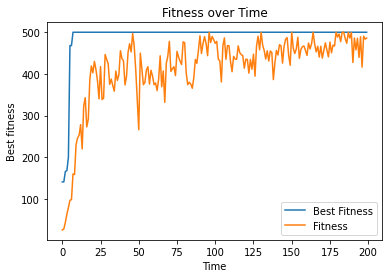

In [ ]:


#Genetic algorithm parameters:
k=5
pcrossover = 0.5
mutation_std = 0.2
num_tournaments, num_individuals = 200, 15
mutation_rate = 0.5
#Cartpole problem
num_obs, num_actions = 4,1

#Set up environment and agent
env_name = 'CartPole-v1'
env = gym.make(env_name)
#env = Recorder(env, '/content/My Drive')

# Create our agent
agent = Agent(num_obs, num_actions)
num_genes = agent.num_genes
# Create our gene population
population = np.random.normal(0, mutation_std, (num_individuals, num_genes))

best_fitness = -9999
best_gene = None
# Get initial fitness of the population
fitness = fitness_function(env, agent, population)
print('Initial fitness: ', fitness)
print(sum(fitness))
#Lists to record the evolution of behaviour
best_fitnesses = []
rewards = []

agents = []

#Add best controller after 0 tournaments
best_gene = get_best_gene(population,fitness)
print(best_gene)
agents.append(get_best_gene(population, fitness))

# Main loop
for epoch in range(num_tournaments):
    
    
    # Get fitness of the population
    # Apply selection based on the fitnesses
    for i in population:
      
      
      #Pick one genotype at random
      g1 = randrange(num_individuals)
      #Pick a second genotype in the local neighbourhood of the first
      g2 = randrange(g1+1, g1 + k)
      #wraparound checker
      if g2 > num_individuals-1:
        #calc how much we over num_types
        wrap_num = g2 - num_individuals
        g2 = wrap_num
      #while g1 == g2:
        #g2 = randrange(num_types)
      #Compare G1 and G2 finding a winner and loser
      w = compare2(g1,g2,population)

      if w == "g1":
        #Copy each gene of the winner to loser with crossover possibility 0.5
        population[g2] = crossover(copy.deepcopy(population[g1]), copy.deepcopy(population[g2]), pcrossover)
        #Add a mutation to the loser and insert it back into the population
        population[g2] = mutation_function(copy.deepcopy(population[g2]), mutation_rate, std=mutation_std)
        population[g1]=copy.deepcopy(population[g1])
      if w == "g2":
        #Copy each gene of the winner to loser with crossover possibility 0.5
        population[g1] = crossover(copy.deepcopy(population[g2]), copy.deepcopy(population[g1]), pcrossover)
        #Add a mutation to the loser and insert it back into the population
        population[g1] = mutation_function(copy.deepcopy(population[g1]), mutation_rate, std=mutation_std)
        population[g2]=copy.deepcopy(population[g2])
      if w == "none":
        #If both genotypes have fitness of 0, mutate both and insert back into population
        population[g2] = mutation_function(copy.deepcopy(population[g2]),mutation_rate, std=mutation_std)
        population[g1] = mutation_function(copy.deepcopy(population[g1]),mutation_rate, std=mutation_std)

      if w == "draw":
        #If both genotypes have the same fitness, choose randomly between them to decide a winner and loser, then crossover, mutate and insert back into population
        rand = randrange(0,1)
        if rand == 0:
          population[g1] = crossover(copy.deepcopy(population[g2]), copy.deepcopy(population[g1]), pcrossover)
          population[g1] = mutation_function(copy.deepcopy(population[g1]),mutation_rate, std=mutation_std)
          population[g1]=copy.deepcopy(population[g1])
        else:
          population[g2] = crossover(copy.deepcopy(population[g1]), copy.deepcopy(population[g2]), pcrossover)
          population[g2] = mutation_function(copy.deepcopy(population[g2]),mutation_rate, std=mutation_std)
          population[g2]=copy.deepcopy(population[g2])
    fitness = fitness_function(env, agent, population)
    
    if best_fitness < fitness.max():
      best_fitness = fitness.max()
    best_fitnesses.append(best_fitness)
    rewards.append(fitness.mean())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Mean fitness of population: {fitness.mean()} | Max fitness of population {best_fitness}")
    if epoch == num_tournaments/2:
        #Add best controller halfway through
        agents.append(get_best_gene(population, fitness))

#Add best controller at the end of optimization
agents.append(get_best_gene(population, fitness))
#env.play()
plt.plot(best_fitnesses, label='Best Fitness')
plt.title('Fitness over Time')
plt.xlabel('Time')
plt.ylabel('Best fitness')
plt.plot(rewards, label='Fitness')
plt.legend()

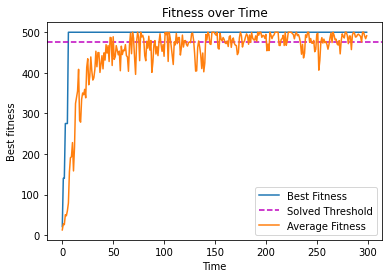

In [ ]:
plt.plot(best_fitnesses, label='Best Fitness')
plt.title('Fitness over Time')
plt.xlabel('Time')
plt.ylabel('Best fitness')
plt.axhline(y=475, label='Solved Threshold', color='m', linestyle='--')
plt.plot(rewards, label='Average Fitness')
plt.legend()
plt.show()

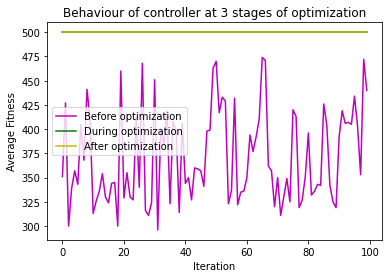

In [ ]:
#The following code runs simulations of the cartpole task for the specified agent
#We then plot the fitness over the number of iterations to show that the performance is not a fluke

init = []
mid = []
final = []
'''
agents_log = np.array(agents_log)

initial_agent = np.array(agents_log[1][0])
mid_agent = np.array(agents_log[0][1])
final_agent = np.array(agents_log[0][2])
'''
initial_agent = agents[0]
mid_agent = agents[1]
final_agent = agents[2]

#Running simulations of the cartpole task for each of the genotypes
agent.set_genes(initial_agent)
for i in range(100):
  init.append(run_episode(env, agent))

agent.set_genes(mid_agent)
for i in range(100):
  mid.append(run_episode(env, agent))

agent.set_genes(final_agent)
for i in range(100):
  final.append(run_episode(env, agent))

plt.figure()
plt.plot(init, label='Before optimization', color='m')
plt.plot(mid, label="During optimization", color='g')
plt.plot(final, label='After optimization', color='y')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.title('Behaviour of controller at 3 stages of optimization')
plt.show()


# Testing with multiple runs to find the average

In [ ]:
def solve_cartpole(num_tournaments, num_individuals):
  '''
  This function wraps a single 'run' of the microbial GA controller
   using the specified number of tournaments and individuals. 
   
   '''
  #Initialise a new population for each run
  population = np.random.normal(0, mutation_std, size=(num_individuals, num_genes)) 
  
  mutation_rate = 0.2
  best_fitness = -9999

  # Get initial fitness of the population
  fitness= fitness_function(env, agent, population)

  #Lists to record the evolution of behaviour
  best_fitnesses = []
  rewards = []
  agents = []

  #Add best controller after 0 tournaments
  agents.append(get_best_gene(population, fitness))

  # Main loop
  for epoch in range(num_tournaments):
      
      
     
      for i in population:
        
        
        #Pick one genotype at random
        g1 = randrange(num_individuals)
        #Pick a second genotype in the local neighbourhood of the first
        g2 = randrange(g1+1, g1 + k)
        #wraparound checker
        if g2 > num_individuals-1:
          #calc how much we over num_types
          wrap_num = g2 - num_individuals
          g2 = wrap_num

        #Compare G1 and G2 finding a winner and loser
        w = compare2(g1,g2,population)

        if w == "g1":
          #Copy each gene of the winner to loser with crossover possibility 0.5
          population[g2] = crossover(copy.deepcopy(population[g1]), copy.deepcopy(population[g2]), pcrossover)
          #Add a mutation to the loser and insert it back into the population
          population[g2] = mutation_function(copy.deepcopy(population[g2]), mutation_rate, std=mutation_std)
          population[g1]=copy.deepcopy(population[g1])
        if w == "g2":
          #Copy each gene of the winner to loser with crossover possibility 0.5
          population[g1] = crossover(copy.deepcopy(population[g2]), copy.deepcopy(population[g1]), pcrossover)
          #Add a mutation to the loser and insert it back into the population
          population[g1] = mutation_function(copy.deepcopy(population[g1]), mutation_rate, std=mutation_std)
          population[g2]=copy.deepcopy(population[g2])
        if w == "none":
          #If both genotypes have fitness of 0, mutate both and insert back into population
          population[g2] = mutation_function(copy.deepcopy(population[g2]),mutation_rate, std=mutation_std)
          population[g1] = mutation_function(copy.deepcopy(population[g1]),mutation_rate, std=mutation_std)

        if w == "draw":
          #If both genotypes have the same fitness, choose randomly between them to decide a winner and loser, then crossover, mutate and insert back into population
          rand = randrange(0,1)
          if rand == 0:
            population[g1] = crossover(copy.deepcopy(population[g2]), copy.deepcopy(population[g1]), pcrossover)
            population[g1] = mutation_function(copy.deepcopy(population[g1]),mutation_rate, std=mutation_std)
            population[g1]=copy.deepcopy(population[g1])
          else:
            population[g2] = crossover(copy.deepcopy(population[g1]), copy.deepcopy(population[g2]), pcrossover)
            population[g2] = mutation_function(copy.deepcopy(population[g2]),mutation_rate, std=mutation_std)
            population[g2]=copy.deepcopy(population[g2])
      
      #Determine the fitness of the new population
      fitness = fitness_function(env, agent, population)
      
      #Check if we have found a new best fitness, if so update the best fitness
      if best_fitness < fitness.max():
        best_fitness = fitness.max()
      
      #Record the best fitness and average fitness for each tournament
      best_fitnesses.append(best_fitness)
      rewards.append(fitness.mean())
      
      #Print the progress of the controller every 10 tournaments
      if epoch % 10 == 0:
          print(f"Epoch: {epoch} | Mean fitness of population: {fitness.mean()} | Max fitness of population {best_fitness}")
      
      #Add best controller halfway through
      if epoch == num_tournaments/2:
          agents.append(get_best_gene(population, fitness))

  #Add best controller at the end of optimization
  agents.append(get_best_gene(population, fitness))
  return rewards, best_fitnesses, agents

In [ ]:
'''
The following code executes 3 runs of the microbial GA controller to calculate average rewards over different populations'''

#Genetic algorithm parameters:
k=5
pcrossover = 0.5
mutation_std = 0.2
num_tournaments, num_individuals = 200, 15

#Cartpole problem
num_obs, num_actions = 4,1

#Set up environment and agent
env_name = 'CartPole-v1'
env = gym.make(env_name)

# Create our gene population


num_runs = 3
reward_log = []
max_reward_log = []
agents_log = []
for i in range(num_runs):
  #Run the controller for 3 runs to determine averages
  reward, max_reward, agents = solve_cartpole(num_tournaments, num_individuals)
  reward_log.append(reward)
  agents_log.append(agents)
  max_reward_log.append(max_reward)

Epoch: 0 | Mean fitness of population: 13.666666666666666 | Max fitness of population 36.0
Epoch: 10 | Mean fitness of population: 186.86666666666667 | Max fitness of population 500.0
Epoch: 20 | Mean fitness of population: 290.6 | Max fitness of population 500.0
Epoch: 30 | Mean fitness of population: 467.73333333333335 | Max fitness of population 500.0
Epoch: 40 | Mean fitness of population: 338.53333333333336 | Max fitness of population 500.0
Epoch: 50 | Mean fitness of population: 332.6666666666667 | Max fitness of population 500.0
Epoch: 60 | Mean fitness of population: 402.2 | Max fitness of population 500.0
Epoch: 70 | Mean fitness of population: 435.53333333333336 | Max fitness of population 500.0
Epoch: 80 | Mean fitness of population: 457.8666666666667 | Max fitness of population 500.0
Epoch: 90 | Mean fitness of population: 478.3333333333333 | Max fitness of population 500.0
Epoch: 100 | Mean fitness of population: 500.0 | Max fitness of population 500.0
Epoch: 110 | Mean fi

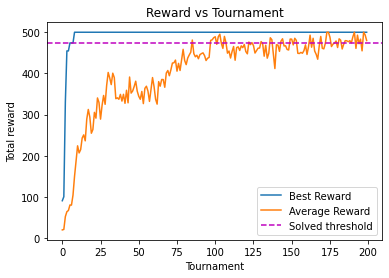

In [ ]:
#Take the average over each run for the cumulative reward and maximum reward
reward_log = np.array(reward_log)
avg_rewards = np.mean(reward_log, axis=0)

max_reward_log = np.array(max_reward_log)
avg_max_reward = np.mean(max_reward_log, axis=0)

plt.plot(avg_max_reward, label='Best Reward')
plt.title('Reward vs Tournament')
plt.xlabel('Tournament')
plt.ylabel('Total reward')
plt.plot(avg_rewards, label='Average Reward')
plt.axhline(y=475, label='Solved threshold', linestyle='--', color='m')
plt.legend()
plt.show()

In [ ]:
def plot_behaviour(fitness,observations, title):
  '''
  This method takes the observations of an agent to plot the change in behaviour through simulations
  First the observations are seperated into the components which represent a state, and then plotted over episodes
  '''

  obs = np.array(observations)


  x = obs[:,0] #Cart position
  x_dot = obs[:,1] #Cart velocity
  theta = obs[:,2] #Pole angle
  theta = np.degrees(theta)
  theta_dot = obs[:,3] #Pole angular velocity

  
  plt.subplots(figsize=(10,5))

  plt.subplot(2,2,1)
  title1='Angle of pole'
  plt.title(title1)
  plt.xlabel('Episode')
  plt.ylabel('Angle in Degrees')
  plt.plot(theta, color='m')

  
  plt.subplot(2,2,2)
  title2 = 'Pole angluar velocity'
  plt.title(title2)
  plt.xlabel('Episode')
  plt.ylabel('Angular velocity')
  plt.plot(theta_dot, color='y')


  plt.subplot(2,2,3)
  title3 = 'Cart position'
  plt.title(title3)
  plt.xlabel('Episode')
  plt.ylabel('Cart position')
  plt.plot(x, color='g')


  plt.subplot(2,2,4)
  title4 = 'Cart velocity'
  plt.title(title4)
  plt.xlabel('Episode')
  plt.ylabel('Cart velocity')
  plt.plot(x_dot, color='r')


  plt.suptitle(title)
  plt.tight_layout()
  #plt.suptitle(title)
  plt.savefig('/content/drive/My Drive/Colab Notebooks/{}'.format(title))
  plt.show()
  

#Initial agent at t=0
initial_agent = agents[0]
init_fitness, init_obs = fitness_function3(env, agent, initial_agent)
#Agent during optimization t=n/2
mid_agent = agents[1]
mid_fitness, mid_obs = fitness_function3(env, agent, mid_agent)
#Final agent after optimization has completed/GA has run
final_agent = agents[2]
final_fitness, final_obs = fitness_function3(env, agent, final_agent)

#Plot each of the behaviours at different stages of optimization
fitnesses=np.array([init_fitness, mid_fitness, final_fitness])
observations=np.array([init_obs, mid_obs, final_obs])
titles=['Before optimization', 'During optimization', 'After optimization']
for i in range(3):
  plot_behaviour(fitnesses[i], observations[i], titles[i])


[0.06973283 1.43413952 3.38552699 2.89421491 0.61322223]


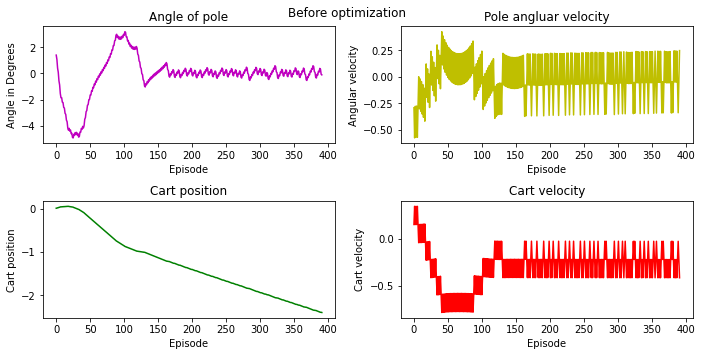

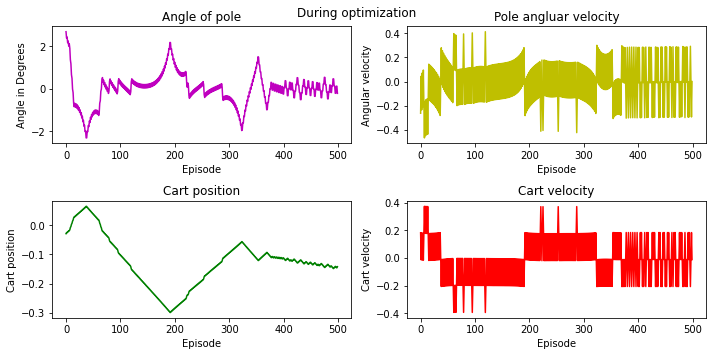

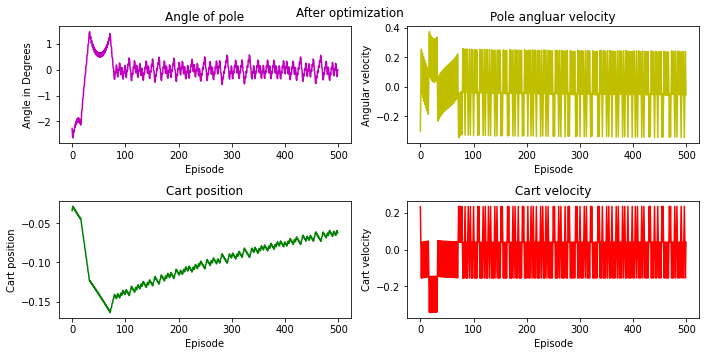

In [ ]:
initial_agent = agents[0]
print(initial_agent)
init_fitness, init_obs = fitness_function3(env, agent, initial_agent)
mid_agent = agents[1]
mid_fitness, mid_obs = fitness_function3(env, agent, mid_agent)
final_agent = agents[2]
final_fitness, final_obs = fitness_function3(env, agent, final_agent)

fitnesses=np.array([init_fitness, mid_fitness, final_fitness])
observations=np.array([init_obs, mid_obs, final_obs])
titles=['Before optimization', 'During optimization', 'After optimization']
for i in range(3):
  plot_behaviour(fitnesses[i], observations[i], titles[i])


## Show the actions of a random agent to compare

In [ ]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()


In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
#rand_agent = RandomAgent(env.action_space)
episode_count = 100
reward = 0
tot_reward = 0
done = False
rewards = []

observations = []
for i in range(episode_count):
    ob = env.reset()
    tot_reward = 0
    rand_agent = RandomAgent(env.action_space)

    while True:
        action = rand_agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        tot_reward += reward

        observations.append(ob)
        if done:
            break
    rewards.append(tot_reward)


Text(0, 0.5, 'Total reward')

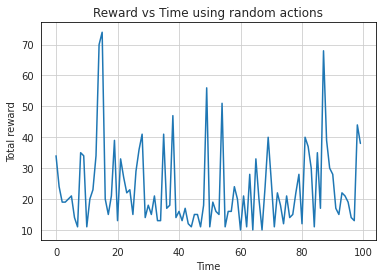

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

random_rewards = []

for i in range(100):
  env.reset()
  done = False
  tot_reward = 0
  while not done:
      action = env.action_space.sample() # put agent here
      obs, reward, done, info = env.step(action)
      tot_reward += reward

  random_rewards.append(tot_reward)
    #print(f"obs{np.round(obs, 2)} reward {reward} action {action} done {done} info {info}")
plt.plot(random_rewards)
plt.title('Reward vs Time using random actions')
plt.xlabel('Time')
plt.ylabel('Total reward')

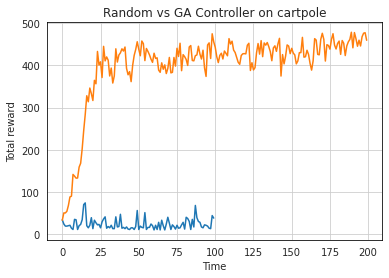

In [ ]:
plt.plot(random_rewards, label='Agent takes random actions')
plt.plot(avg_rewards, label='GA Controller')
plt.title('Random vs GA Controller on cartpole')
plt.ylabel('Total reward')
plt.xlabel('Time')
plt.show()